# Credit Card Fraud Detection
## Introduction
There is evident a very high rise in E-comm in the previous couple of years and credit cards along with E-money became the most preferred mean of payment. Unfortunately, this also results in raise of illegal activities, such as fraudulent payment.

There are many payment service providers nowadays and many of them are fighting to prevent the existing problem. However, simple pattern matching techniques are often not good enough.

This is where data science can help. We want to solve this ever-growing problem in the financial market by implementing advanced machine learning techniques. This is not a straightforward task for two reasons:

*   the fraudulent behaviors usually differ for each attempt
*   datasets are usually highly imbalanced


## Project Objective
Objective of the project is to perform predictive analysis on the credit card transaction data set using machine learning techniques and detect the fraudulent transactions from the given dataset. Main idea is to identify if a transaction comes under normal class or fraudulent class using predictive machine learning models.


## Dataset
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where 492 are frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. It contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, the original features and more background information about the data is not provided. The only features that are not transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning.

In [1]:
"""
PACKAGE IMPORTS
"""
import gdown

# Data exploration
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mathematical libraries
import numpy as np # linear algebra
import scipy.stats as stats # statistics
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, roc_auc_score

The helper function below returns precision, recall, f1 and very importantly Roc Auc Score. This is important because we are dealing with higly imbalanced dataset. 

ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

Bigger area under the curve (will be seen later) is associated with better predicitons. 

In [2]:
"""
HELPER FUNCTIONS
"""

"""
This method is used for evaluating performance of the prediction
"""
def evaluate(y_test, y_pred):
  precision, recall, _ = precision_recall_curve(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rac = roc_auc_score(y_test, y_pred)
  return precision, recall, f1, rac


In [3]:
url = "https://drive.google.com/uc?id=1iVcc9gVOZBYa6eXph8O58sVERt6NCFc3&confirm=t"

output = 'creditcard.csv'
gdown.download(url, output, quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1iVcc9gVOZBYa6eXph8O58sVERt6NCFc3&confirm=t
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:02<00:00, 55.5MB/s]


'creditcard.csv'

In [4]:
# Load data
df = pd.read_csv('/content/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory data analysis

There are 284807 samples, and 31 rows.

In [5]:
df.shape

(284807, 31)

As it can be seen below, the data that is not transformed using PCA are indeed time and amount. 

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


There are no null values in the dataset, which is very good. There is no need for removal of data in the dataset.

In [7]:
df.isnull().values.sum()

0

The dataset is highly unbalanced, there are 284315 fraudulent transactions, and 492 fraudulent transactions. Oversampling/undersampling techniques are implemented to tackle the problem.

Most real-world applications possess unbalanced class distribution where the number of a class label heavily dominates another class label. One of the best examples to explain the class imbalance problem is the fraud detection task, where the number of fraud class labels is deficient compared to the normal class label. Most machine learning algorithms work poorly in the presence of unbalanced class distribution (i.e., the predictive model tends to classify the minority example as the majority example).

In [8]:
# compare classes
counts = df.Class.value_counts()
non_fraudulent = counts[0]
fraudulent = counts[1]
perc_normal = (non_fraudulent/counts.sum())*100
perc_fraudulent = (fraudulent/counts.sum())*100
print('There were {} non-fraudulent transactions ({:.3f}%) and {} fraudulent transactions ({:.3f}%).'.format(non_fraudulent, 
                                                                                                             perc_normal, 
                                                                                                             fraudulent, 
                                                                                                             perc_fraudulent))

There were 284315 non-fraudulent transactions (99.827%) and 492 fraudulent transactions (0.173%).


Below is the barplot graph which very well visualizes the imbalance in the dataset. The number of fraudulent transactions looks almost inexistent.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


284807

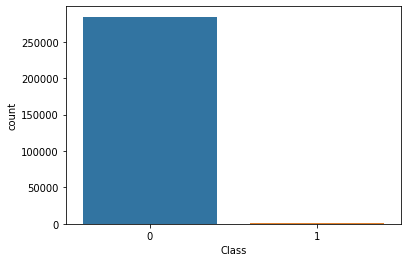

In [9]:
# visual representation of classes
sns.countplot(df["Class"])
df["Class"].count().sum()

Correlation table below shows some significant negative correlations, especially with Time and Amount predictors. This most probably occurs because Time and Value are still not scaled, which is one of next steps in solution development.

Text(0.5, 1.0, 'Features Correlation Heatmap')

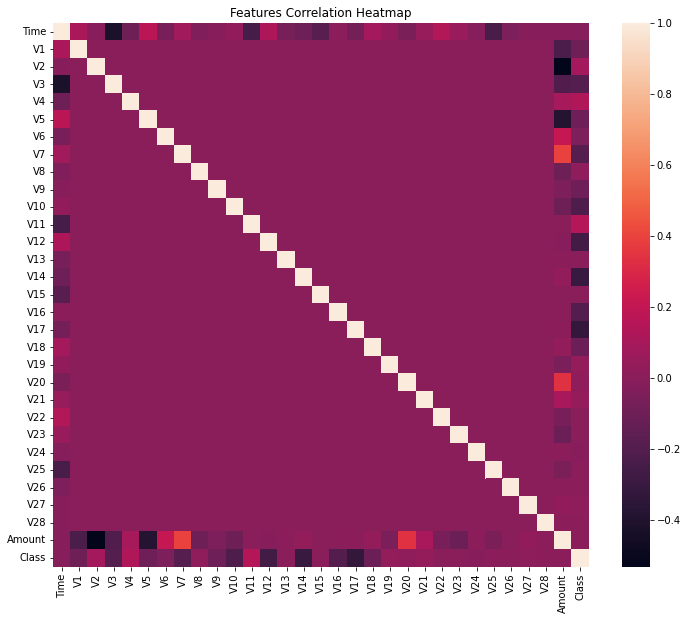

In [10]:
#heatmap
corr = df.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr)
plt.title('Features Correlation Heatmap')

The dataset already went through the PCA transformation and in order to implement the PCA transformation, the data needs to be scaled, and therefore it is assumed that data was scaled. Data is split into train and test samples, taking into consideration that dataset is imbalanced. Scaling of the data is performed afterwards.



In [11]:
X = df.drop("Class", axis=1)
y = df["Class"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.4)
X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()

In [13]:
print(y_train.value_counts())
print('-' * 50)
print("There are " + str(100*(y_train.value_counts()[1]/y_train.value_counts().sum()))+ " % of fraudulent datapoints in the training sample.")

0    170589
1       295
Name: Class, dtype: int64
--------------------------------------------------
There are 0.17263172678542169 % of fraudulent datapoints in the training sample.


In [14]:
y_test.value_counts()
print('-' * 50)
print ("There are " + str(y_test.value_counts()[1]/y_test.value_counts().sum()) + " % of fraudulent datapoints in the test sample.")

--------------------------------------------------
There are 0.0017292381696408978 % of fraudulent datapoints in the test sample.


After doing the splits, let's scale the unscaled data. First check for the outliers to make a decision on the scaler.

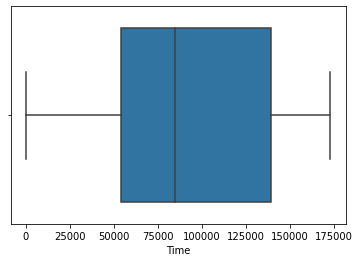

In [15]:
sns.boxplot(x=X_train["Time"])

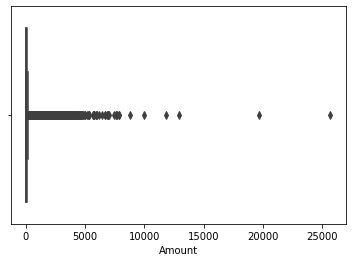

In [16]:
sns.boxplot(x=X_train["Amount"])

As it can be seen in the box-plots above, time does not have a lot of outliers, but Amount is very scattered and we have to take this into an account. Therefore we will use Robust Scaler for scaling the data. 2 objects are initialized, for amount and time respectively and perform transformations

In [17]:
scaler_amount = RobustScaler()
X_train["Amount"] = scaler_amount.fit_transform(X_train['Amount'].values.reshape(-1,1))
X_test["Amount"] = scaler_amount.transform(X_test["Amount"].values.reshape(-1,1))
scaler_time = RobustScaler()
X_train["Time"] = scaler_time.fit_transform(X_train["Time"].values.reshape(-1,1))
X_test["Time"] = scaler_time.transform(X_test["Time"].values.reshape(-1,1))

SMOTE will be performed for most of the models because our data is highly imbalanced. 

If the dataset is not balanced (or performed bagging), the model will be biased towards legitimate transactions, and model will most probably behave very poorly on the real world data, and it will not generalize well. To tackle this problem, Synthetic Minority Over-Sampling Technique (SMOTE) is employed.

## Baseline Models

*   Logistic Regression
*   KNN
*   Random Forrest Classifier

This is just a starting point for the model testing! It will be expanded on the results in the next couple of steps.

This step consists of building pipelines in which we apply SMOTE and then train the model. We could consider putting the robust scaler in the pipline, but for this project it was decided to use the scaler before fitting because all the other columns are already scaled, and it is not beneficial to scale the entire dataset, but just two columns.

In [ ]:
sm = SMOTE()
base_models = [('LR', make_pipeline(SMOTE(random_state=42), LogisticRegression())),
               ('KNN', make_pipeline(SMOTE(random_state=42), KNeighborsClassifier())),
               ('RF', make_pipeline(SMOTE(random_state=42), RandomForestClassifier()))]

baseline_results = []
for name, model in base_models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  precision, recall, f1, rac = evaluate(y_test,y_pred)
  baseline_results.append((name, precision, recall, f1, rac))

The results of baseline models are plotted to see in what direction to move with cross-validation and more advanced and tuned models.

f1 scores: 
LR 0.10603397773872289, AUC = 0.9460429917449644
KNN 0.58, AUC = 0.9406175596506734
RF 0.8563968668407311, AUC = 0.9161469311179931


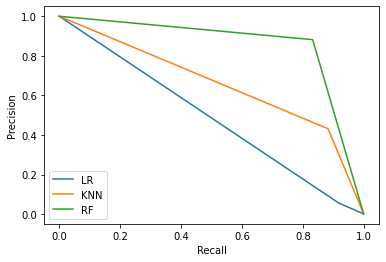

In [19]:
print("f1 scores: ")
for name, precision, recall, f1, rac in baseline_results:
  print(str(name) + " " + str(f1) + ", AUC = " + str(rac))
  plt.plot(recall, precision, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

As it can be seen, Ensemble methods classifiers tend to work the best. This is the next step where the goal it to implement boosting methods on the classifier. F1 score is already quite good for the base random forrest classifier, but boosting methods and cross validation usually result in even better results. Hyperparameter tuning for the Random Forest classifier is investigated initially and after that results are compared with boosting methods and some more advanced methods.

## Hyperparameter tuning for Random Forest Classifier


In [ ]:
# Number of trees in the random forest
n_estimators = [int(x) for x in np.linspace(start=200 , stop=800, num=4)]

# Max features
max_features = ['auto', 'sqrt']

# Max depth
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)

param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3)

grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
precision, recall, f1 = evaluate(y_test,y_pred)
rac = roc_auc_score(y_test, y_pred)
print("f1: " + str(f1))
print("AUC: " + str(rac))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Advanced Methods

In [ ]:
advanced_models = [('AdaBoost', make_pipeline(SMOTE(random_state=42), AdaBoostClassifier())),
                   ('GradientBoostingClassifier', make_pipeline(SMOTE(random_state=42), GradientBoostingClassifier())),
                   ("Extra Trees", make_pipeline(SMOTE(random_state=42), ExtraTreesClassifier()))]

advanced_results = []
for name, model in advanced_models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  precision, recall, f1, rac = evaluate(y_test,y_pred)
  advanced_results.append((name, precision, recall, f1, rac))

In [ ]:
print("f1 scores: ")
for name, precision, recall, f1, rac in advanced_results:
  print(str(name) + " " + str(f1) + ", AUC = " + str(rac))
  plt.plot(recall, precision, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Model Discussion
The best model found was Extra Trees model and Random Forest model (f1 scores 0.8509485094850948 and 0.8517520215633422 respectively). Some models had a quite large AUC score, but didn't perform amazingly on the test values. Therefore, it is safe to assume that some models over fit the training dataset. Room for improvement exists, especially for hyperparameter tuning which was implemented, but in a limited portion because of high computational needs for cross validation.

It is important to point out that AUC (Area under ROC) is problematic especially since the data is imbalanced. This kind of situations is very common in action detection, fraud detection, bankruptcy prediction ect. That is, the positive examples you care have relatively low rates of occurrence. With imbalanced data, the AUC still gives you specious value around 0.8. However, it is high due to large FP, rather than the large TP (True positive).

# Conclusion
Firstly, one might ask why didn't we do outlier detection for all the variables, but just for time and amount. The reason for this is because our dataset is already transformed for V paramaters and we assumed that all the data that is given to us is indeed important. Even though we have some correlation concerns, we decided not to drop any of the values that might be outliers at this point.

In our future works, we want to implement the best model in real world to see how it behaves. We are happy with our results. Furthermore, we might want to experiment with neural networks and some more complex models.

# References
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019

Yann-Aël Le Borgne, Gianluca Bontempi Reproducible machine Learning for Credit Card Fraud Detection - Practical Handbook

Bertrand Lebichot, Gianmarco Paldino, Wissam Siblini, Liyun He, Frederic Oblé, Gianluca Bontempi Incremental learning strategies for credit cards fraud detection, IInternational Journal of Data Science and Analytics
